<a href="https://colab.research.google.com/github/Carlos-mack/Projeto-Aplicado-II/blob/main/c_pia_de_untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
import os
from PIL import Image
import matplotlib.pyplot as plt
os.environ['KAGGLE_USERNAME'] = 'cabatista'
os.environ['KAGGLE_KEY'] = 'f4986fe9f8c1b6dd42b0d028996dc7ae'
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification
!unzip cats-and-dogs-image-classification.zip -d /content/CATS_DOGS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 67% 43.0M/64.4M [00:00<00:00, 91.7MB/s]
100% 64.4M/64.4M [00:00<00:00, 105MB/s] 
Archive:  cats-and-dogs-image-classification.zip
  inflating: /content/CATS_DOGS/test/cats/cat_1.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_106.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_109.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_113.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_114.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_116.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_118.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_119.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_124.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_140.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_147.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_156.jpg  
  inflating: /content/CATS_DOGS/test/cats/cat_158.jpg  
  inflating: /content/CATS_DOGS/test/cats/ca

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
17/17 [==============================] - 279s 17s/step - loss: 0.7519 - accuracy: 0.5643 - val_loss: 0.6317 - val_accuracy: 0.6641 - lr: 1.0000e-04
Epoch 2/50
17/17 [==============================] - 301s 18s/step - loss: 0.6952 - accuracy: 0.5848 - val_loss: 0.6077 - val_accuracy: 0.6797 - lr: 1.0000e-04
Epoch 3/50
17/17 [==============================] - 274s 16s/step - loss: 0.5813 - accuracy: 0.6781 - val_loss: 0.5553 - val_accuracy: 0.6797 - lr: 1.0000e-04
Epoch 4/50
17/17 [==============================] - 307s 18s/step - loss: 0.5292 - accuracy: 0.7371 - val_loss: 0.4734 - val_accuracy: 0.7422 - lr: 1.0000e-04
Epoch 5/50
17/17 [==============================] - 300s 18s/step - loss: 0.4854 - accuracy: 0.7695 - val_loss: 0.4440 - val_accuracy: 0.7734 - lr: 1.0000e-04
Epoch 6/50
17/17 [==============================] - 305s 1

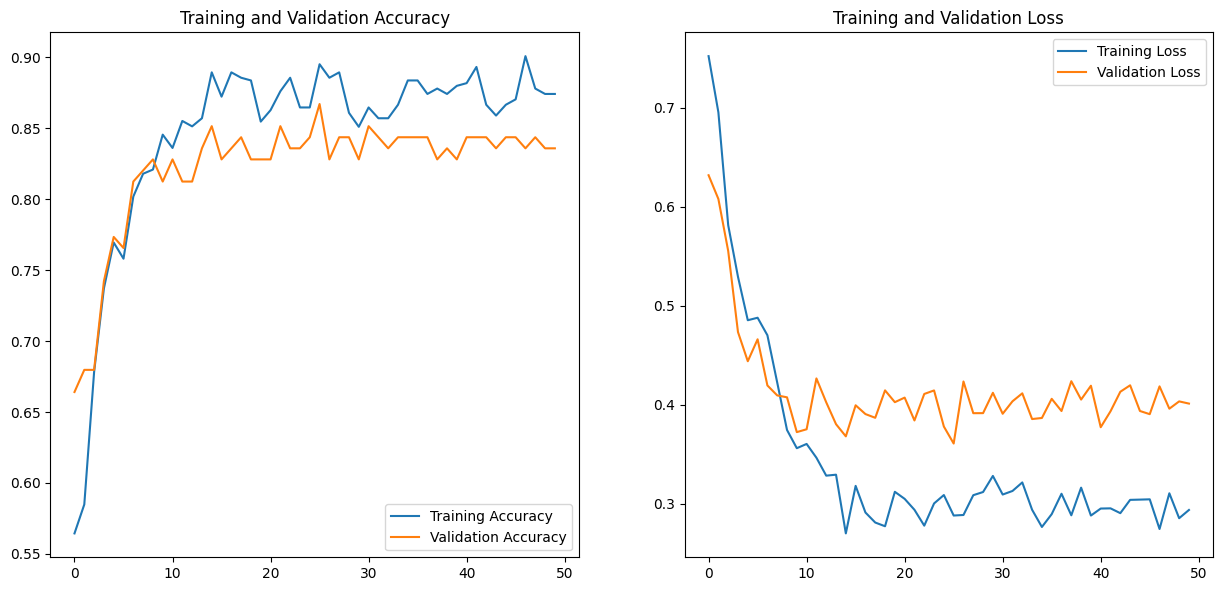

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, 
                                       Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Definir caminho para os dados de treino e teste
train_dir = '/content/CATS_DOGS/train'
test_dir = '/content/CATS_DOGS/test'

# Definir tamanho do batch e número de épocas
batch_size = 32
epochs = 50

# Definir gerador de dados de treino com aumento de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Definir gerador de dados de teste sem aumento de dados
test_datagen = ImageDataGenerator(rescale=1./255)

# Definir geradores de fluxo de dados de treino e teste
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Carregar modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adicionar camadas de rede neural no topo do modelo VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar camadas do modelo VGG16 para evitar que sejam treinadas novamente
for layer in base_model.layers:
    layer.trainable = False

# Compilar modelo com ReduceLROnPlateau
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Treinar modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size,
    callbacks=[reduce_lr]
)

# Avaliar modelo
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy:", test_acc)

# Plotar curva de aprendizado
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()